<a href="https://colab.research.google.com/github/z-arabi/SRU-deeplearning-workshop/blob/master/21_Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The basic idea behind a cGAN is to condition both the generator and discriminator on some extra information, e.g., the class label.

In [3]:
!git clone https://github.com/z-arabi/SRU-deeplearning-workshop.git
%cd SRU-deeplearning-workshop

Cloning into 'SRU-deeplearning-workshop'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 341 (delta 59), reused 114 (delta 51), pack-reused 213
Receiving objects: 100% (341/341), 37.58 MiB | 21.99 MiB/s, done.
Resolving deltas: 100% (158/158), done.
/content/SRU-deeplearning-workshop/SRU-deeplearning-workshop


# GAN

In [33]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, LeakyReLU
from keras.datasets import mnist
from keras.optimizers.legacy import Adam
from keras import initializers
from classFiles.dataset import load_hoda

import tensorflow as tf

## Optimizer

In [8]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
# define the dimension of the output > hyperparameter
randomDim = 100

# Load MNIST data
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Load HODA data
# Load pre-shuffled HODA data into train and test sets
X_train, y_train, _, _ = load_hoda(training_sample_size=60000,
                             test_sample_size=400,size=28)
X_train = np.array(X_train)
y_train = np.array(y_train)

# 0 - 255 >> -1 to 1
X_train = (X_train.astype(np.float32) - 127.5)/127.5

# we want to train it with MLP
# MLPs are generally used for 1D data, so 2D data like images
# are usually flattened before being used as input.
X_train = X_train.reshape(60000, 784)

# Optimizer
# beta_1 is a hyperparameter for the exponential decay rate of the first moment (or "moving average") of the gradient.
# The value is usually close to 1, with common default values being 0.9 or 0.999,
# but in some contexts like training GANs, a beta_1 value of 0.5 is sometimes recommended.
adam = Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
y_train.shape

(60000,)

In [16]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_train_onehot.shape, y_train[3500], y_train_onehot[3500]

((60000, 10),
 8,
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32))

beta_1 is a hyperparameter for the exponential decay rate of the first moment (or "moving average") of the gradient. Adam keeps an exponentially decaying average of past gradients $m_t$, which is computed as:  
$$
m_t = \beta_1 \times m_{t-1} + (1 - \beta_1) \times \text{gradient}_t
$$
This $m_t$ is then used in the parameter update rule.

## Generator

In [20]:
# we have to give two inputs to the network, so we need functional API
from keras.layers import Concatenate

noise = Input(shape=(randomDim,))
label_g = Input(shape=(10,))  # one-hot encoded labels (assuming 10 classes)

g = Concatenate()([noise, label_g])

g = Dense(256)(g)
g = LeakyReLU(0.2)(g)
g = Dense(512)(g)
g = LeakyReLU(0.2)(g)
g = Dense(1024)(g)
g = LeakyReLU(0.2)(g)
output_layer = Dense(784, activation='tanh')(g)

# Creating the generator model
generator = Model(inputs=[noise, label_g], outputs=output_layer)
generator.compile(loss='binary_crossentropy', optimizer=adam)

## Discriminator

In [25]:
image = Input(shape=(784,))
label_d = Input(shape=(10,))  # one-hot encoded labels (assuming 10 classes)

d = Concatenate()([image, label_d])

d = Dense(1024)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.3)(d)
d = Dense(512)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.3)(d)
d = Dense(256)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.3)(d)
output_layer = Dense(1, activation='sigmoid')(d)

# Creating the generator model
discriminator = Model(inputs=[image, label_d], outputs=output_layer)
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

## Final Network
 In each time just one of the networks can be trained.

In [27]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
label = Input(shape=(10,))
x = generator([ganInput, label])
ganOutput = discriminator([x,label])
gan = Model(inputs=[ganInput, label], outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

## Other Functions

In [48]:
out_dir = "./gan"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    out = os.path.join(out_dir, 'cgan_loss_epoch_%d.png' % epoch)
    plt.savefig(out)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    # This generates an array of shape [batchSize, randomDim] filled with random numbers.
    # These numbers are drawn from a normal distribution with mean 0 (mu = 0) and standard deviation 1 (sigma = 1).
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    tiled_array = np.tile(to_categorical(7, 10), (examples, 1))
    generatedImages = generator.predict([noise,tiled_array])
    # the output of generator is flatten
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    out = os.path.join(out_dir, 'cgan_generated_image_epoch_%d.png' % epoch)
    plt.savefig(out)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('./cgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('./cgan_discriminator_epoch_%d.h5' % epoch)

## Train GAN

In [49]:
X_train.shape

(60000, 784)

In [50]:
epochs=100
batchSize=128

# number of iterations
batchCount = X_train.shape[0] // batchSize
print ('Epochs:', epochs)
print ('Batch size:', batchSize)
print ('Batches per epoch:', batchCount)

Epochs: 100
Batch size: 128
Batches per epoch: 468


In [51]:
from tensorflow.keras.utils import to_categorical

one_hot_vector = to_categorical(7, 10)
tiled_array = np.tile(to_categorical(7, 10), (batchSize, 1))
one_hot_vector, tiled_array

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]], dtype=float32))

  0%|          | 0/100 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
4/4 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
  1%|          | 1/100 [01:40<2:46:11, 100.72s/it]

--------------- Epoch 2 ---------------


  2%|▏         | 2/100 [03:22<2:45:15, 101.18s/it]

--------------- Epoch 3 ---------------


  3%|▎         | 3/100 [04:51<2:34:39, 95.66s/it] 

--------------- Epoch 4 ---------------


  4%|▍         | 4/100 [06:20<2:28:42, 92.95s/it]

--------------- Epoch 5 ---------------


  5%|▌         | 5/100 [07:51<2:26:32, 92.55s/it]

--------------- Epoch 6 ---------------


  6%|▌         | 6/100 [09:21<2:23:13, 91.42s/it]

--------------- Epoch 7 ---------------


  7%|▋         | 7/100 [10:51<2:21:10, 91.08s/it]

--------------- Epoch 8 ---------------


  8%|▊         | 8/100 [12:20<2:18:24, 90.27s/it]

--------------- Epoch 9 ---------------


  9%|▉         | 9/100 [13:47<2:15:47, 89.53s/it]

--------------- Epoch 10 ---------------
4/4 [==============================] - 0s 9ms/step


 10%|█         | 10/100 [15:22<2:16:25, 90.95s/it]

--------------- Epoch 11 ---------------


 11%|█         | 11/100 [16:50<2:13:36, 90.07s/it]

--------------- Epoch 12 ---------------


 12%|█▏        | 12/100 [18:19<2:11:34, 89.71s/it]

--------------- Epoch 13 ---------------


 13%|█▎        | 13/100 [19:46<2:09:14, 89.13s/it]

--------------- Epoch 14 ---------------


 14%|█▍        | 14/100 [21:14<2:07:07, 88.70s/it]

--------------- Epoch 15 ---------------


 15%|█▌        | 15/100 [22:41<2:05:06, 88.31s/it]

--------------- Epoch 16 ---------------


 16%|█▌        | 16/100 [24:11<2:03:59, 88.57s/it]

--------------- Epoch 17 ---------------


 17%|█▋        | 17/100 [25:39<2:02:21, 88.46s/it]

--------------- Epoch 18 ---------------


 18%|█▊        | 18/100 [27:08<2:01:05, 88.60s/it]

--------------- Epoch 19 ---------------


 19%|█▉        | 19/100 [28:38<2:00:13, 89.05s/it]

--------------- Epoch 20 ---------------
4/4 [==============================] - 0s 5ms/step


 20%|██        | 20/100 [30:10<1:59:56, 89.95s/it]

--------------- Epoch 21 ---------------


 21%|██        | 21/100 [31:39<1:58:02, 89.65s/it]

--------------- Epoch 22 ---------------


 22%|██▏       | 22/100 [33:07<1:56:07, 89.32s/it]

--------------- Epoch 23 ---------------


 23%|██▎       | 23/100 [34:38<1:54:58, 89.59s/it]

--------------- Epoch 24 ---------------


 24%|██▍       | 24/100 [36:06<1:53:04, 89.27s/it]

--------------- Epoch 25 ---------------


 25%|██▌       | 25/100 [37:34<1:51:06, 88.89s/it]

--------------- Epoch 26 ---------------


 26%|██▌       | 26/100 [39:03<1:49:29, 88.77s/it]

--------------- Epoch 27 ---------------


 27%|██▋       | 27/100 [40:33<1:48:27, 89.14s/it]

--------------- Epoch 28 ---------------


 28%|██▊       | 28/100 [42:00<1:46:14, 88.53s/it]

--------------- Epoch 29 ---------------


 29%|██▉       | 29/100 [43:28<1:44:36, 88.39s/it]

--------------- Epoch 30 ---------------
4/4 [==============================] - 0s 5ms/step


 30%|███       | 30/100 [45:00<1:44:31, 89.59s/it]

--------------- Epoch 31 ---------------


 31%|███       | 31/100 [46:30<1:42:55, 89.50s/it]

--------------- Epoch 32 ---------------


 32%|███▏      | 32/100 [47:58<1:41:10, 89.27s/it]

--------------- Epoch 33 ---------------


 33%|███▎      | 33/100 [49:27<1:39:33, 89.15s/it]

--------------- Epoch 34 ---------------


 34%|███▍      | 34/100 [51:06<1:41:17, 92.08s/it]

--------------- Epoch 35 ---------------


 35%|███▌      | 35/100 [52:35<1:38:47, 91.20s/it]

--------------- Epoch 36 ---------------


 35%|███▌      | 35/100 [53:06<1:38:38, 91.05s/it]


KeyboardInterrupt: ignored

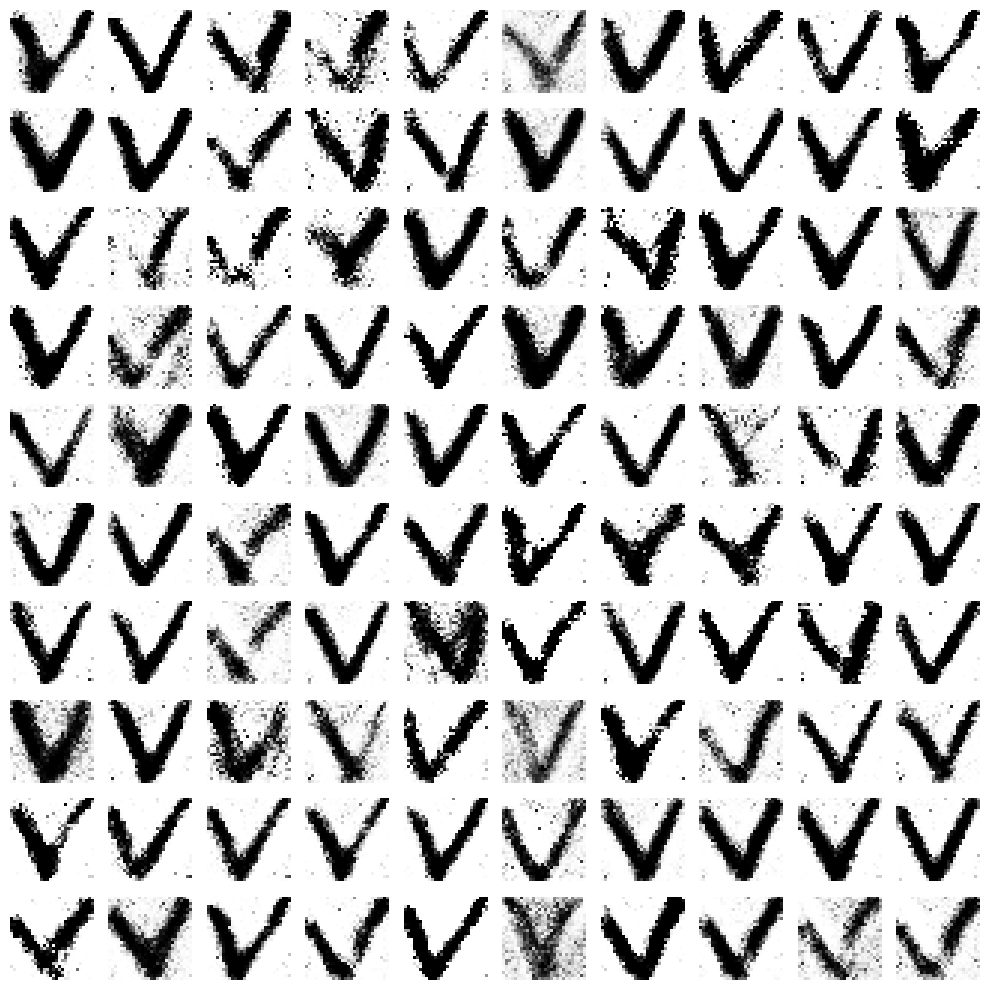

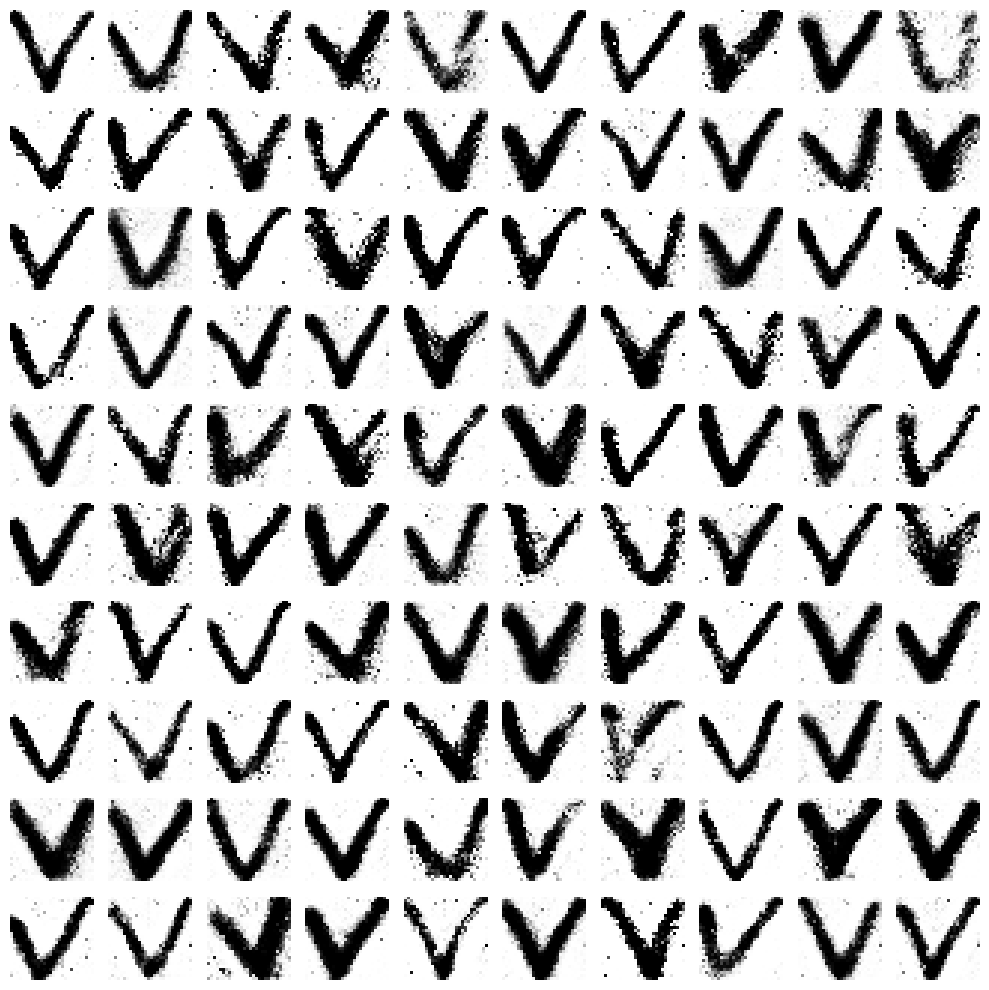

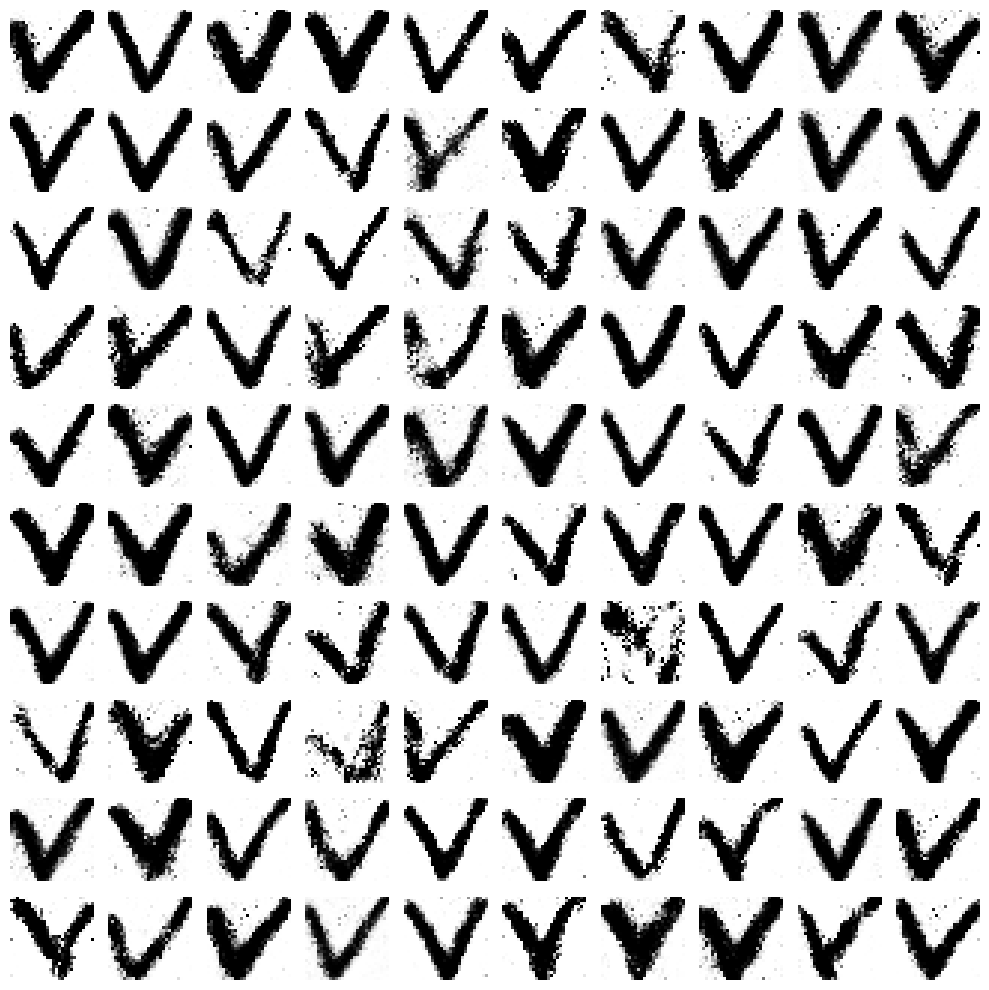

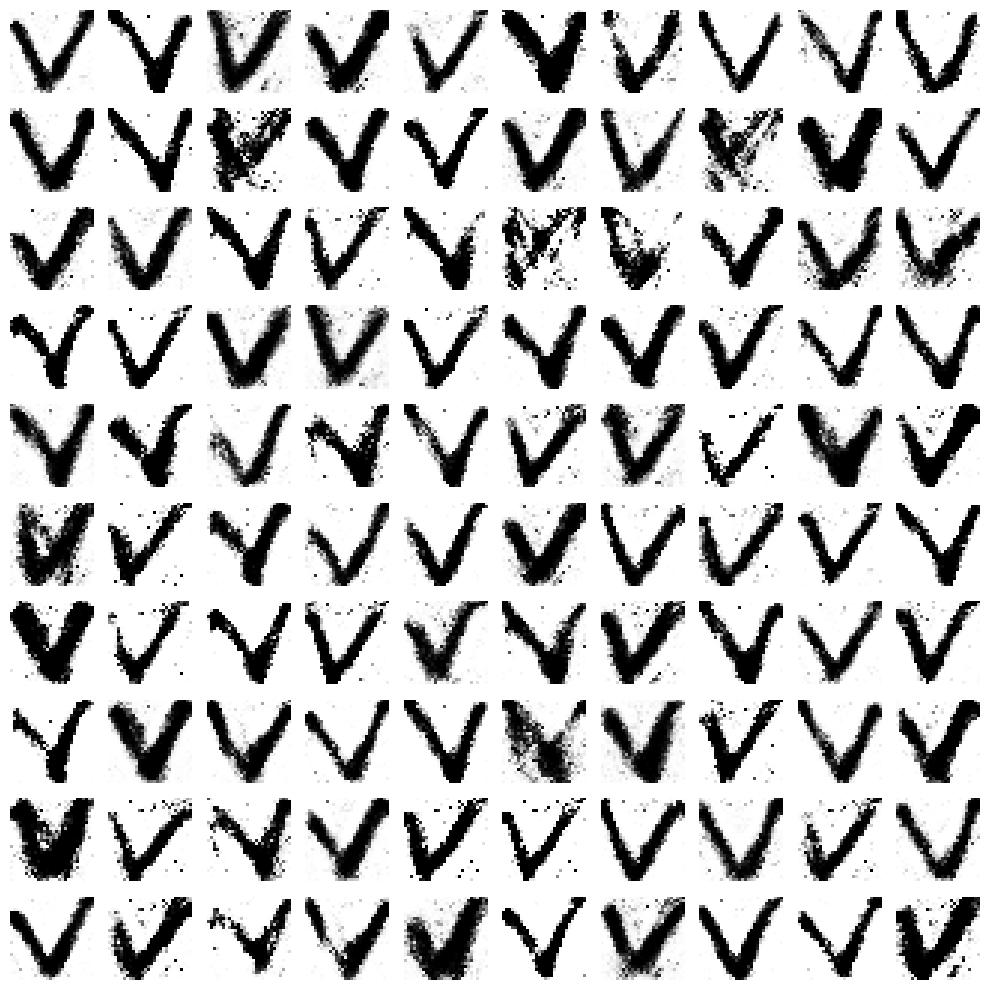

In [52]:
for e in tqdm(range(1, epochs+1)):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in range(batchCount):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])

        # This generates batchSize random integers between 0 and X_train.shape[0] - 1.
        # These integers serve as the indices for randomly selecting images from the X_train dataset.
        # We don't need to compair the labels, we just need to see the batchSize data and detect whether
        # they are similar or not
        inds = np.random.randint(0, X_train.shape[0], size=batchSize)
        imageBatch = X_train[inds]
        imageBatch_label = y_train_onehot[inds]

        # Generate fake MNIST images
        # generates a one-hot encoded representation of the number 7 with a vector size of 10.
        tiled_array = np.tile(to_categorical(7, 10), (batchSize, 1))
        generatedImages = generator.predict([noise, tiled_array],verbose=0)
        # print np.shape(imageBatch), np.shape(generatedImages) >> 256*image_size [the mid of array is real and other fake]
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # here we have to label > the real ones for 1 and fake ones to 0
        # We have label smoothing, which help to train > instead of 1 = 0.9 and instead of 0 = 0.1
        # One-sided label smoothing > instead of 1 just put 0.9
        yDis[:batchSize] = 0.9

        y_labels = np.concatenate([imageBatch_label, tiled_array])

        # Train discriminator
        discriminator.trainable = True
        # min-batch for discriminator is 256 but for generator is 128
        # The attribute model.metrics_names will give you the display labels for the scalar outputs.
        # the default calue is loss but it can be define to show more: metrics=['accuracy'], ['loss','accuracy','AUC']
        dloss = discriminator.train_on_batch([X, y_labels], yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        # step1 > we have two types of data real and fake [0,1] > fed into D > D train
        # step2 > D is locked > we give noise as input and label 1 for G > D now have to day they are real/fake
        # now the loss will update the G too
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch([noise, tiled_array], yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == 1 or e % 10 == 0:
        plotGeneratedImages(e)
        saveModels(e)

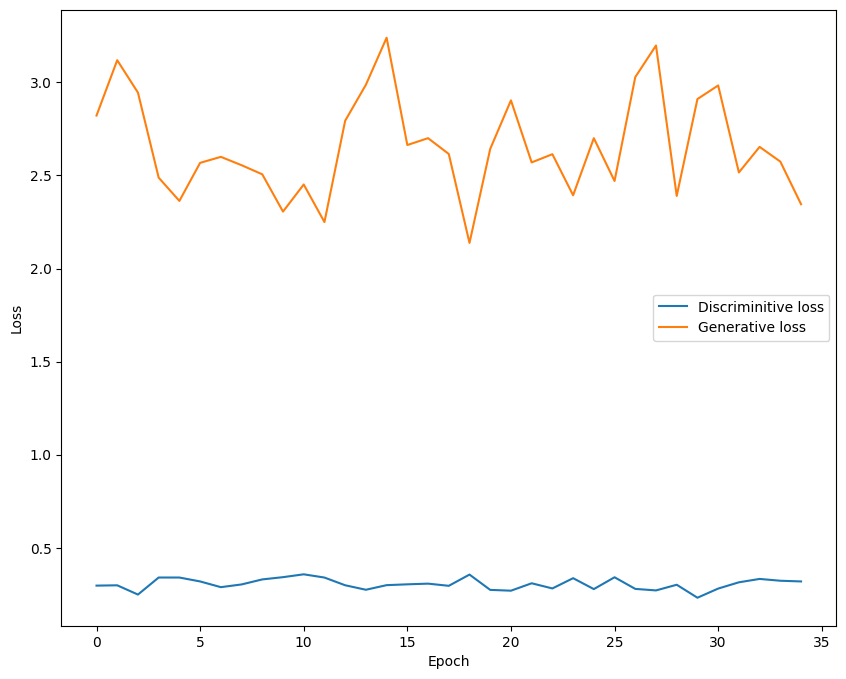

In [53]:
# loss of G must be better (lower)
# loss of D must be worser (higher)

# Plot losses from every epoch
plotLoss(e)